In [1]:
import numpy as np
import keras
from keras import models, layers
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.layers import Dense

import matplotlib.pyplot as plt
import matplotlib.patches as patches


import scipy.io
import cv2
import os

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
HANDS_DATASET = '../data/original/hand_dataset'

IMAGE_TEST_DIR = os.path.join(HANDS_DATASET, 'test_dataset/test_data')
IMAGE_VALIDATION_DIR = os.path.join(HANDS_DATASET, 'validation_dataset/validation_data')
IMAGE_TRAIN_DIR = os.path.join(HANDS_DATASET, 'training_dataset/training_data')

IMAGE_SHAPE=(128, 128, 3)
MAX_HANDS_TO_DETECT = 4
FLATTENED_DIMENSIONS = MAX_HANDS_TO_DETECT * 4 * 2


In [3]:
conv_base = load_model('../data/models/2018-10-09 20:54:49___0.940677957009461.h5')

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       147584    
__________

In [5]:
# Create new model
# Get input
new_input = conv_base.input
# Find the layer to connect
hidden_layer = conv_base.layers[-2].output
# Connect a new layer on it
new_output = Dense(2) (hidden_layer)
# Build a new model
conv_base = Model(new_input, new_output)

In [6]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 128)       0         
__________

In [7]:
def load_annotations(file):
    f = scipy.io.loadmat(file)
    #print(f.keys())
    #print(f['boxes'])
    #print(f)
    data = f.get('boxes')
    data = np.array(data)
    
    # We only want the rectangular points from each annotation
    image_annotations = []
    for hand in data[0]:
        # I'm not entirely sure why, but the shape of each file seems to be wrapped in a lot of empty lists
        polygon_points = hand[0][0]
        # We only want the first four items (that actually make up the polygon)
        polygon_points = list(polygon_points)[:4]
        # Again, each point has an empty list wrapped around
        polygon_points = [point[0] for point in polygon_points]
        # points are actually reversed, we want them to be [x, y], but matlab really likes them as [y, x]
        image_annotations.append([[point[1], point[0]] for point in polygon_points])
        

    return image_annotations

len(load_annotations('/Users/kjprice/Library/Projects/smu/capstone/data/original/hand_dataset/validation_dataset/validation_data/annotations/Movie_4weds_1.mat'))


5

### Pull images/annotations from directory

In [8]:
limit_data = 10

def load_annotations_from_dir(directory):
    annotations_dir = os.path.join(directory, 'annotations')
    annotation_files = os.listdir(annotations_dir)
    annotations_for_all_files = []
    i = 0
    for annotation_file in annotation_files:
        if limit_data > -1 and i == limit_data:
            break
        # ignore config files
        if annotation_file.find('.') == 0:
            continue
        matlab_filepath = os.path.join(annotations_dir, annotation_file)
        annotations = load_annotations(matlab_filepath)
        annotations_for_all_files.append(annotations)
        i += 1
    return annotations_for_all_files

def load_images_from_dir(directory):    
    images_dir = os.path.join(directory, 'images')
    images = os.listdir(images_dir)

    imgs = [] # TODO: Delete

    i = 0
    for _file in images:
        if limit_data > -1 and i == limit_data:
            break
        # ignore config files
        if _file.find('.') == 0:
            continue
        filepath = os.path.join(images_dir, _file)
        img = load_img(filepath, target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        
        img_ORIGINAL = load_img(filepath)
        #imgs.append(img_ORIGINAL)
        imgs.append(img_to_array(img_ORIGINAL))
        i += 1

        
    return imgs

### Resize images annotations

In [9]:
# Takes a list of images and their correalted annotations (each image has a matching annotation)
def resize_images_and_annotations(images, annotations):
    if len(images) != len(annotations):
        raise Exception('Length of images {} does not match length of annotations'.format(images, annotations))
        global MAX_HANDS_TO_DETECT, FLATTENED_DIMENSIONS
        
    
    new_images = []
    new_annotations = []
    for (image, annotation) in zip(images, annotations):
        resized_image = cv2.resize(image, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        
        original_height, original_width, original_depth = image.shape
        resized_image = cv2.resize(image, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        new_height, new_width, new_depth = resized_image.shape
        width_change = new_width / original_width
        height_change = new_height / original_height

        new_annotation = []
        for hand_count in range(MAX_HANDS_TO_DETECT):
            # we have run out of hands, insert a hand with no points
            if len(annotation) <= hand_count:
                new_annotation.append([[0, 0], [0, 0], [0, 0], [0, 0]])
                continue
            hand = annotation[hand_count]

            new_hand = []
            for point in hand:
                x, y = point
                new_x = x * width_change
                new_y = y * height_change
                new_point = [new_x, new_y]
                new_hand.append(new_point)

            new_annotation.append(new_hand)

        new_annotations.append(new_annotation)
        new_images.append(resized_image)
        flattened_annotations = np.reshape(new_annotations, (len(new_annotations), FLATTENED_DIMENSIONS))
    return (new_images, flattened_annotations)

### Load images and annotations

In [10]:
def load_images_as_np(directory):
    
    input_shape = (IMAGE_SHAPE[2], IMAGE_SHAPE[1], IMAGE_SHAPE[0])

    images_original = load_images_from_dir(directory)
    annotations_original = load_annotations_from_dir(directory)
    
    x_dataset, y_dataset = resize_images_and_annotations(images_original, annotations_original)


            
    return x_dataset, y_dataset

In [11]:
%time x_train, y_train = load_images_as_np(IMAGE_TRAIN_DIR)

CPU times: user 207 ms, sys: 28.6 ms, total: 235 ms
Wall time: 224 ms


In [12]:
%time x_val, y_val = load_images_as_np(IMAGE_VALIDATION_DIR)

CPU times: user 239 ms, sys: 24.2 ms, total: 263 ms
Wall time: 253 ms


In [13]:
%time x_test, y_test = load_images_as_np(IMAGE_TEST_DIR)

CPU times: user 136 ms, sys: 18.9 ms, total: 155 ms
Wall time: 146 ms


In [14]:
# takes a list of flat annotations and will turn them into actual polygon shapes (around hands)
def hands_from_flat_annotation(annotation):
    annotation = np.array(annotation)
    return annotation.reshape(4, 4, 2).tolist()
    
def hands_from_flat_annotations(annotations):
    return [hands_from_flat_annotation(annotation) for annotation in annotations]
np.array(hands_from_flat_annotations(y_train)).shape

(10, 4, 4, 2)

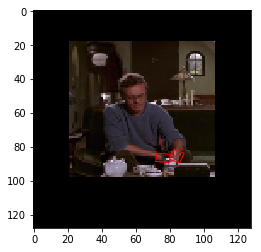

In [15]:
def display_image_with_annotation(img, annotations, ax = plt.gca()):
    plt.imshow(array_to_img(img))
    annotations = hands_from_flat_annotation(annotations)
    for annotation in annotations:
        line = plt.Polygon(annotation, fill=None, edgecolor='r')
        ax.add_patch(line)

first_annotations_from_first_video = y_train[0]
first_image = x_train[0]
display_image_with_annotation(first_image, first_annotations_from_first_video)

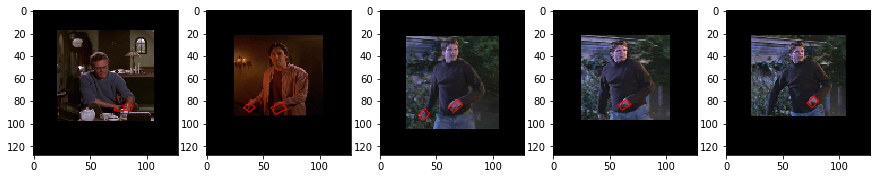

In [16]:
def display_images_with_annotations(imgs, annotations):
    i = 1
    num_rows = 1
    num_cols = len(imgs)
    f = plt.figure(figsize=(15,5))
    for img, annotation in zip(imgs, annotations):
        ax = f.add_subplot(1, num_cols, i)
        display_image_with_annotation(img, annotation, ax)
        i += 1
        

display_images_with_annotations(x_train[:5], y_train[:5])

In [17]:
model = models.Sequential()
model.add(conv_base)

# model.add(layers.Flatten()) # flatten layer already exists
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(FLATTENED_DIMENSIONS)) # linear
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])


In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2)                 2601666   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
Total params: 2,610,658
Trainable params: 2,610,658
Non-trainable params: 0
_________________________________________________________________


In [19]:
def plot_mae(history):
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    plt.plot(epochs, mae, 'bo', label='Training mae')
    plt.plot(epochs, val_mae, 'b', label='Validation mae')
    plt.title('Training and validation mae')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training mae')
    plt.plot(epochs, val_loss, 'b', label='Validation mae')
    plt.title('Training and validation mae')
    plt.legend()

    plt.show()

In [23]:
def callback(x, y):
    y_predictions = model.predict([x_test])
    display_images_with_annotations(x_test[:5], y_predictions[:5])

lambda_callback = keras.callbacks.LambdaCallback(on_epoch_end=callback)


Train on 10 samples, validate on 10 samples
Epoch 1/2
10/10 [==============================] - 0s 50ms/step - loss: 419.9792 - mean_absolute_error: 13.7401 - val_loss: 2391.9966 - val_mean_absolute_error: 34.8870
yo
Epoch 2/2
10/10 [==============================] - 1s 57ms/step - loss: 424.8382 - mean_absolute_error: 12.8343 - val_loss: 2814.6979 - val_mean_absolute_error: 39.2576
yo
CPU times: user 3.89 s, sys: 994 ms, total: 4.88 s
Wall time: 1.36 s


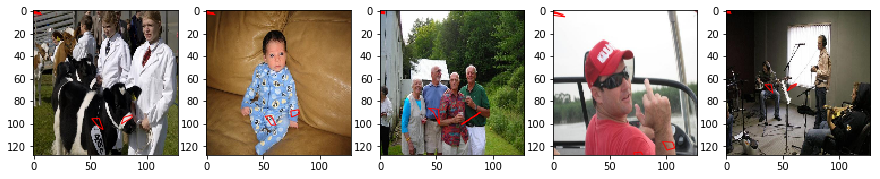

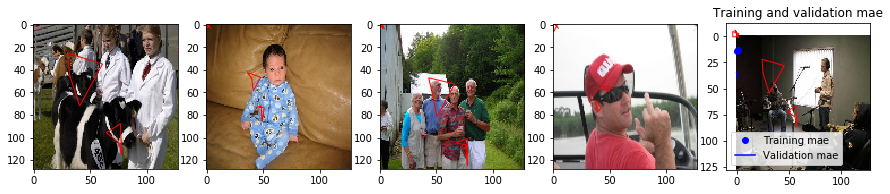

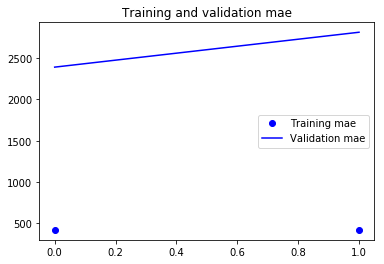

In [24]:
num_epochs = 2
%time history = model.fit([x_train], y_train, \
                          epochs=num_epochs, batch_size=1, verbose=1, \
                          validation_data=([x_val], y_val), \
                          callbacks=[lambda_callback])

plot_mae(history)

In [22]:
len(load_annotations('/Users/kjprice/Library/Projects/smu/capstone/data/original/hand_dataset/validation_dataset/validation_data/annotations/Movie_4weds_1.mat'))


5